# CIFAR 10 Classifier

Load and normalize CIFAR10

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

Determine the device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Train data information:\n',train_set)
print('Test data information:\n',test_set)

Train data information:
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data information:
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Preparing data for training with DataLoaders \
We will remove 10,000 images from the training set and call this our validation set. The dataset also includes labels for each image.Set the batch size to B = 20. This means that we will pass through the entire data in 2000 iterations, which is called on epoch. We will use `DataLoader` to split and assemble data in 3 sets and shuffle in each set.

In [7]:
from torch.utils.data import DataLoader,Subset
# Set random seed
np.random.seed(0)
order = np.random.permutation(len(train_set))
validation = Subset(train_set, order[0:10000])
train = Subset(train_set, order[10000:])
batch_size = 20

loaders = {
    'train' : DataLoader(train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0),
    
    'validation' : DataLoader(validation, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0),
    
    'test'  : DataLoader(test_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1bf4286b520>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x1bf4286bd30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1bf4286b8e0>}

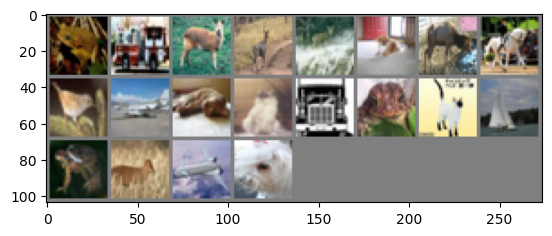

frog  truck deer  deer  deer  dog   deer  horse bird  plane cat   cat   truck frog  cat   ship  frog  deer  plane dog  


In [10]:
import matplotlib.pyplot as plt

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loaders['train'])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Create a CNN model

In [11]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1                  
            ),
            nn.BatchNorm2d(32), # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )        
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.conv3 = nn.Sequential(         
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),     
            nn.ReLU(),
            nn.MaxPool2d(2),                
        )
        
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=.3)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x



Use GPU\
By default, the tensors are generated on the CPU. Even the model is initialized on the CPU. Thus one has to manually ensure that the operations are done using GPU. 
We need to transform the input,output and model to GPU.

In [12]:
learning_rate = 0.001
epochs = 30

In [13]:
model = CNN()
criterion = nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [14]:
length_tr = len(loaders['train'])
length_val = len(loaders['validation'])
loss_validation = torch.zeros((epochs,1), dtype=torch.float64).to(device)
acc_validation = torch.zeros((epochs,1), dtype=torch.float64).to(device)
accuracy_val_list = torch.empty((length_val,1), dtype=torch.float64).to(device)
loss_train = torch.zeros((epochs,1), dtype=torch.float64).to(device)
acc_train = torch.zeros((epochs,1), dtype=torch.float64).to(device)
accuracy_tr_list = torch.empty((length_tr,1), dtype=torch.float64).to(device)


In [15]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [16]:
# Loop over epochs
for epoch in range(epochs):    
    # Loop over batches in an epoch using DataLoader
    loss_tr = torch.empty((length_tr,1), dtype=torch.float64).to(device)
    loss_val = torch.empty((length_val,1), dtype=torch.float64).to(device)
    #Training set
    for id_batch, (x_batch, y_batch) in enumerate(loaders['train']):
    # Remember that you will have to send the inputs and targets at every step to the GPU too:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch)
        loss_tr[id_batch][0] = loss
        
        optimizer.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
    
        total_tr = y_batch.size(0)
        correct_tr = (torch.argmax(y_batch_pred,dim=1) == y_batch).sum()
        accuracy_tr = 100 * correct_tr / total_tr
        accuracy_tr_list[id_batch][0] = accuracy_tr
   
    acc_train[epoch][0] = torch.mean(accuracy_tr_list,dtype=torch.float64)    
    loss_train[epoch][0] = torch.mean(loss_tr,dtype=torch.float64 )
    print(f'epoch:{epoch+1}\t Train_loss pro epoch:{loss_train[epoch][0]}\ Accuracy pro epoch:{acc_train[epoch][0]}')
    
    # Validation set
    for id_batch, (x_batch, y_batch) in enumerate(loaders['validation']):
        
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch_pred = model(x_batch)       
        validation_loss = criterion(y_batch_pred, y_batch)
        loss_val[id_batch][0] = validation_loss
        optimizer.zero_grad()
        validation_loss.backward()
        optimizer.step()
        
        total_val = y_batch.size(0)
        correct_val = (torch.argmax(y_batch_pred,dim=1) == y_batch).sum()
        accuracy_val = 100 * correct_val / total_val
        accuracy_val_list[id_batch][0] = accuracy_val

    acc_validation[epoch][0] = torch.mean(accuracy_val_list,dtype=torch.float64) 
    loss_validation[epoch][0] = torch.mean(loss_val,dtype=torch.float64)
    print(f'epoch:{epoch+1}\t Validation_loss pro epoch:{loss_validation[epoch][0]}\ Accuracy pro epoch:{acc_validation[epoch][0]}')
    
print('Finished Training')

epoch:1	 Train_loss pro epoch:1.698593224734068\ Accuracy pro epoch:36.27
epoch:1	 Validation_loss pro epoch:1.4686129294633865\ Accuracy pro epoch:46.22
epoch:2	 Train_loss pro epoch:1.3168302184045315\ Accuracy pro epoch:52.6275
epoch:2	 Validation_loss pro epoch:1.1950424565672875\ Accuracy pro epoch:57.230000000000004
epoch:3	 Train_loss pro epoch:1.1101668139249086\ Accuracy pro epoch:60.9475
epoch:3	 Validation_loss pro epoch:1.0357424880862236\ Accuracy pro epoch:63.45
epoch:4	 Train_loss pro epoch:0.9728030898720026\ Accuracy pro epoch:66.4525
epoch:4	 Validation_loss pro epoch:0.8959758615493775\ Accuracy pro epoch:69.12
epoch:5	 Train_loss pro epoch:0.866078037828207\ Accuracy pro epoch:70.4225
epoch:5	 Validation_loss pro epoch:0.8094165338873863\ Accuracy pro epoch:72.3
epoch:6	 Train_loss pro epoch:0.7803264435753227\ Accuracy pro epoch:73.5625
epoch:6	 Validation_loss pro epoch:0.7340151905417442\ Accuracy pro epoch:74.68
epoch:7	 Train_loss pro epoch:0.7110768590196967\ 

In [17]:
PATH = './cifar_net_1.pth'
torch.save(model.state_dict(), PATH)

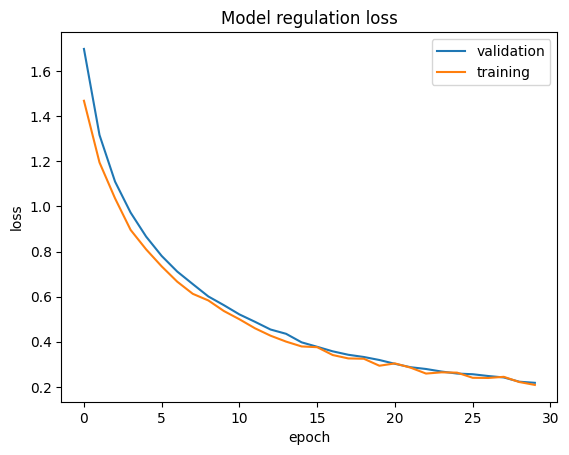

In [18]:
plt.plot(loss_train.cpu().detach().numpy().tolist())
plt.plot(loss_validation.cpu().detach().numpy().tolist())
plt.legend(['validation','training'])
plt.title('Model regulation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

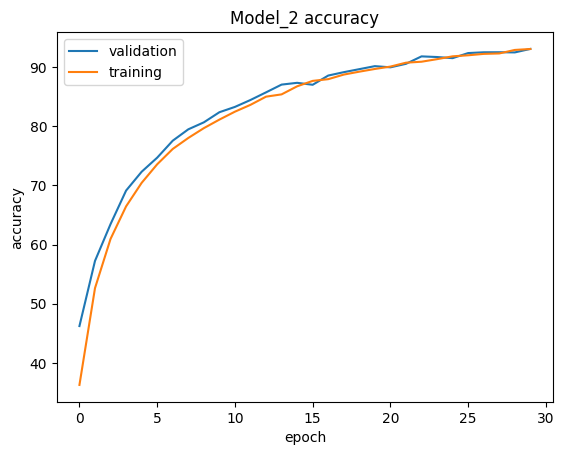

In [22]:
plt.plot(acc_validation.cpu().detach().numpy().tolist())
plt.plot(acc_train.cpu().detach().numpy().tolist())
plt.legend(['validation','training'])
plt.title('Model_2 accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [20]:
model.load_state_dict(torch.load('cifar_net_1.pth'))
model.eval()

for test_x, test_y in loaders['test']:
    test_x, test_y = test_x.to(device).float(),test_y.to(device).float()
    outputs = model(test_x)
    total_test = batch_size
    correct_test = (torch.argmax(outputs,dim=1) == test_y).sum()
    acc_test = 100 * correct_test / total_test

print(acc_test.cpu().detach().numpy().tolist())

85.0
